In [1]:
import os
import copy
import time
import asyncio
import warnings
import logging

from pathlib import Path

import numpy as np
from astropy.io import fits

from scipy import ndimage
from scipy.signal import medfilt
from scipy.ndimage.filters import gaussian_filter
from astropy.modeling import models, fitting


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 6]

#Import CWFS package
from lsst import cwfs
from lsst.cwfs.instrument import Instrument
from lsst.cwfs.algorithm import Algorithm
from lsst.cwfs.image import Image, readFile, aperture2image, showProjection
import lsst.cwfs.plots as plots

%matplotlib inline

In [2]:
import wget

In [4]:
from lsst.ts import salobj
from lsst.ts.standardscripts.auxtel.attcs import ATTCS
import asyncio

In [5]:
attcs = ATTCS()
cam = salobj.Remote(attcs.domain, "GenericCamera", 1)

In [7]:
await asyncio.gather(attcs.start_task, cam.start_task) 

[[None, None, None, None, None, None, None], None]

## Declare target

In [8]:
# Declare target name
target_name='HD82741'

In [9]:
# Print Hexapod Current position (given by last successful command)
curr_hex_pos = await attcs.athexapod.evt_positionUpdate.aget(timeout=10)
print('Current Hexapod position from evt_positionUpdate: \n x= {}, \n y= {}, \n z= {}, \n U= {}, \n V= {}'
      .format(curr_hex_pos.positionX, curr_hex_pos.positionY, curr_hex_pos.positionZ, curr_hex_pos.positionU, curr_hex_pos.positionV))

Current Hexapod position from evt_positionUpdate: 
 x= -4.34999460265, 
 y= 0.100000922561, 
 z= 0.518000115253, 
 U= 0.349999710943, 
 V= 0.219999517238


In [53]:
hex_X, hex_Y, hex_Z, hex_U, hex_V, hex_R = [-4.350, 0.100, 0.518, 0.350, 0.220, 0.000]

hex_X, hex_Y, hex_Z, hex_U, hex_V, hex_R = [-4.350, 0.100, 0.518-0.060, 0.350, 0.220, 0.000]

print('Command to Hexapod in-focus position')
await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, 
                                                   y=hex_Y,
                                                   z=hex_Z, 
                                                   u=hex_U, 
                                                   v=hex_V)

Command to Hexapod in-focus position


In [54]:
dz=1.5
expTime=30.0

In [55]:
# await cam.cmd_stopLiveView.start()

In [56]:
try:
    await cam.cmd_stopLiveView.start()
except salobj.AckError:
    print("ack error")

# Intrafocal hexapod setting - offsets -0.5mm from central focus value above

print('Move to intrafocal position')
await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
                                             z=hex_Z-dz, u=hex_U, v=hex_V)

print('Take intrafocal image')
cam.evt_endReadout.flush()

await cam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName=target_name+'_intra')

intra_endron = await cam.evt_endReadout.next(flush=False, timeout=1)

print(intra_endron.imageName)

# Extrafocal hexapod setting
print('Move to extra-focal hexapod position')
await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
                                                     z=hex_Z+dz, u=hex_U, v=hex_V)

# r.evt_endReadout.flush()
print('Take extra-focal image')
cam.evt_endReadout.flush()
await cam.cmd_takeImages.set_start(numImages=1, expTime=expTime, shutter=True, imageSequenceName=target_name+'_extra')

extra_endron = await cam.evt_endReadout.next(flush=False, timeout=1)

print(extra_endron.imageName)

try:
    await cam.cmd_startLiveView.set_start(expTime=0.5)
except salobj.AckError:
    print("ack error")

await attcs.athexapod.cmd_moveToPosition.set_start(x=hex_X, y=hex_Y,
                                         z=hex_Z, u=hex_U, v=hex_V)


intra_wget_url = 'http://139.229.170.216:8000/data/'+intra_endron.imageName+'.fits'
extra_wget_url = 'http://139.229.170.216:8000/data/'+extra_endron.imageName+'.fits'
intra_fname = wget.download(intra_wget_url)
print(f'{intra_fname}')
extra_fname = wget.download(extra_wget_url)
print(f'{extra_fname}')


Move to intrafocal position
Take intrafocal image
1579834188-HD82741_intra-0-1
Move to extra-focal hexapod position
Take extra-focal image
1579834225-HD82741_extra-0-1
Grabbed/Wrote intra-focal |image 1579834188-HD82741_intra-0-1.fits via wget
Grabbed/Wrote extra-focal |image 1579834225-HD82741_extra-0-1.fits via wget


In [44]:
intra_fname,extra_fname

('1579833798-HD82741_intra-0-1.fits', '1579833836-HD82741_extra-0-1.fits')

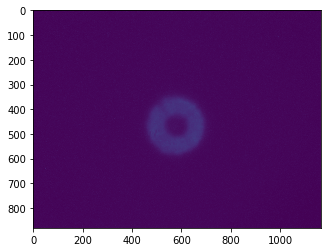

In [57]:
# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(extra_fname))[0].data

# Show images added together to estimate centroid
plt.imshow(intra_exp+extra_exp)

In [58]:
# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=250
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    im_filtered = medfilt(im,[5,5])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

9 65
Creating stamps of centroid [y,x] = [465,576] with a side length of 150 pixels


RemoteTelemetry(ATDome, 0, position) falling behind; read 11 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 45 messages
RemoteEvent(ATMCS, 0, target) falling behind; read 46 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 12 messages


In [59]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 11 messages
RemoteTelemetry(ATPtg, 0, guidingAndOffsets) falling behind; read 11 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 12 messages


In [60]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.
algo=Algorithm('exp',inst,1) # example - but only want 11 Zernikes (Num_of_Zernikes)



Offset should be :20.5 [mm] at the focus, 0.5 [mm] at the hexapod
Offset in file is :61.5 [mm] at the focus
pixelSize should be: 1.44e-05


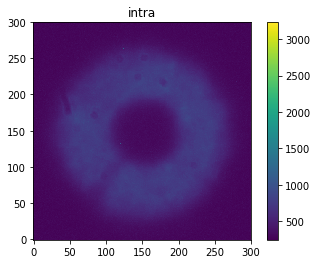

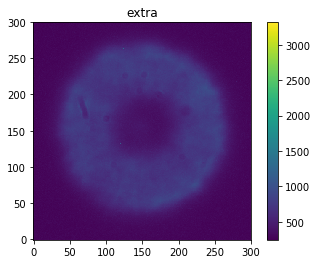

Extra-focal filename: 1579834225-HD82741_extra-0-1.fits
Intra-focal filename: 1579834188-HD82741_intra-0-1.fits


RemoteEvent(ATMCS, 0, target) falling behind; read 15 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 15 messages


In [61]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')
print('Extra-focal filename: {}'.format(extra_fname))
print('Intra-focal filename: {}'.format(intra_fname))

In [62]:
algo.runIt(inst,I1,I2,'onAxis')

In [40]:
print(algo.zer4UpNm)

[293.45994264  16.05155052 -31.35673792   1.94353452  -1.64047067
 -76.15706794 -15.97385835 -12.78669378 -10.26043566  -4.32328531
  -1.64984776 -17.30662625   6.03428358   6.54018563   2.48590009
  -4.99371364   6.00810352 -15.17673035  -2.83074754]


In [51]:
print(algo.zer4UpNm)

[-93.14545502 -54.21828007 -31.19745036  20.51843462 -16.39737363
 -57.52127534  50.19186307 -15.59500589 -13.1941287    0.19204848
 -13.05462394 -12.06608801   6.67371121  -0.86102603   0.20403311
   1.44028845   0.27218826   6.7711197    0.30178492]


RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteEvent(ATDome, 0, heartbeat) falling behind; read 72 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 73 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 71 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 72 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 72 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 72 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 71 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 73 messages
RemoteEvent(ATAOS, 0, logMessage) f

In [63]:
print(algo.zer4UpNm)

[ 61.28424969 -46.63915    -76.7546444    5.01718442   6.52495056
 -25.41526767  26.3891471   -6.70995257   0.93945221   2.13659504
 -27.95644818   7.32741593   7.22886131   3.4714244   -9.42661055
   3.16997679   9.28779224   3.46223091  -5.64814362]


RemoteEvent(ATMCS, 0, target) falling behind; read 100 messages
RemoteEvent(ATDomeTrajectory, 0, logMessage) falling behind; read 100 messages
RemoteTelemetry(ATDome, 0, position) falling behind; read 100 messages
RemoteTelemetry(ATPtg, 0, currentTargetStatus) falling behind; read 100 messages
RemoteTelemetry(ATPneumatics, 0, loadCell) falling behind; read 73 messages
RemoteTelemetry(ATHexapod, 0, positionStatus) falling behind; read 71 messages
RemoteEvent(GenericCamera, 1, logMessage) falling behind; read 74 messages
RemoteEvent(ATAOS, 0, heartbeat) falling behind; read 72 messages


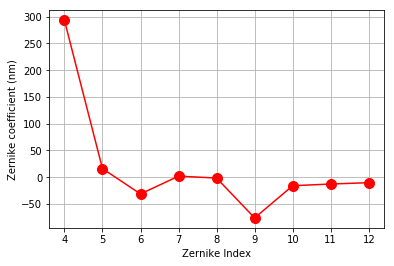

In [41]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

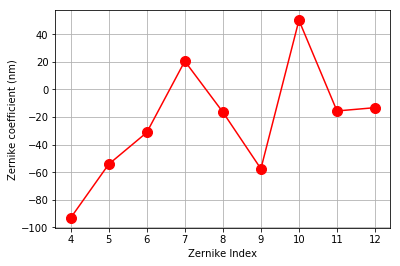

In [52]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

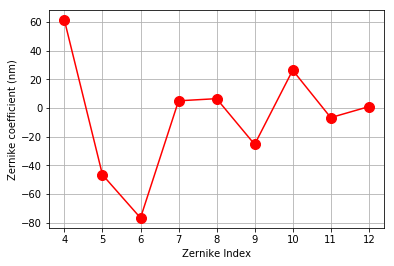

RemoteTelemetry(ATPneumatics, 0, mainAirSourcePressure) falling behind; read 73 messages
RemoteTelemetry(ATPtg, 0, timeAndDate) falling behind; read 100 messages
RemoteTelemetry(ATMCS, 0, trajectory) falling behind; read 73 messages
RemoteEvent(ATDomeTrajectory, 0, heartbeat) falling behind; read 73 messages
RemoteEvent(ATDome, 0, heartbeat) falling behind; read 73 messages
RemoteEvent(ATHexapod, 0, heartbeat) falling behind; read 73 messages
RemoteTelemetry(ATPneumatics, 0, m2AirPressure) falling behind; read 74 messages
RemoteEvent(GenericCamera, 1, heartbeat) falling behind; read 71 messages
RemoteTelemetry(ATPtg, 0, skyEnvironment) falling behind; read 14 messages
RemoteTelemetry(ATMCS, 0, torqueDemand) falling behind; read 74 messages
RemoteTelemetry(ATPneumatics, 0, m1AirPressure) falling behind; read 74 messages
RemoteTelemetry(ATPtg, 0, mountStatus) falling behind; read 100 messages
RemoteEvent(ATAOS, 0, logMessage) falling behind; read 44 messages
RemoteTelemetry(ATMCS, 0, nas

In [64]:
# plot the zernikes
plots.plotZer(algo.zer4UpNm[0:9],'nm')

In [ ]:
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
logger = logging.getLogger('image_display_notebook')

In [ ]:
def calc_CofM(array, offset=(0,0)):
    # Function takes a a 2d Array and computes the CofM
    
    # offset is the coordinate of the minimum y and x pixel
    
    
    #just make it easier to parse the code below
    shape=array.shape
        
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, shape[0], 1)+ offset[0]
    ones_array_2d=np.ones([shape[1], shape[0]])
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # Can't just use the transpose of the y_index_arr_2d
    # since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, shape[1], 1) + offset[1]
    ones_array_2d=np.ones([shape[0], shape[1]])
    # array will be left to right so need to transpose
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d

    # Calculate the centroid
    y_CofM = np.sum(y_index_arr_2d*array)/np.sum(array)
    x_CofM = np.sum(x_index_arr_2d*array)/np.sum(array)
    
    logger.info('y_CofM is {}'.format(y_CofM))
    logger.info('x_CofM is {}'.format(x_CofM))

    return(y_CofM, x_CofM)

In [ ]:
# This is just used to test the CofM algorithm.

def make_circle(yxdims, radius, center=None):
    
    #Creates a circle where the internal pixels equal 1 and the rest are zero
    
    #dims is y,x dimensions
    
    # If center isn't declared then put it at the center of the box
    if center==None:
        center=(yxdims[0]/2, yxdims[1]/2)
    
    # Build 2d index arrays for calculations
    pix_index_1d_arr=np.arange(0, yxdims[1] , 1) - center[1]
    ones_array_2d=np.ones((yxdims[0], yxdims[1]))
    x_index_arr_2d=pix_index_1d_arr*ones_array_2d
    
    # Can't just transpose x-indice array since we're supporting non-symmetrical arrays
    pix_index_1d_arr=np.arange(0, yxdims[0], 1) - center[0]
    ones_array_2d=np.ones((yxdims[1],yxdims[0]))
    # array will be left to right so need to transpose
    y_index_arr_2d=np.transpose(pix_index_1d_arr*ones_array_2d)
    
    # creates an array with a given side, and a circle of radius x and position xy
    r_arr= np.sqrt(y_index_arr_2d**2 + x_index_arr_2d**2)
    
    arr=np.zeros((yxdims[0],yxdims[1]) ,dtype=float)
    
    arr[r_arr < radius] = 1
    return(arr)

In [ ]:
# Testing the CofM code
center=(1400,750)
stamp=make_circle((2500,1400), 100, center=center)

calc_CofM(stamp)

# Now try with subimage and reference to corner
side=300
guess_center = np.array((1550, 610))
stamp2= stamp[guess_center[0]-side:guess_center[0]+side, 
              guess_center[1]-side:guess_center[1]+side].copy()
calc_CofM(stamp2, offset=(guess_center-side))

if False:
    fig, ax = plt.subplots(figsize=(7,6))
    ax.imshow(stamp, interpolation='none')
    stamp.shape

    fig2, ax2 = plt.subplots(figsize=(7,6))
    ax2.imshow(stamp2, interpolation='none')
    stamp2.shape

In [ ]:
# Declare where data is located and where output will be written, notably the stacked doughnuts
data_folder = Path("/home/saluser/data/20191212")
output_folder = Path("/home/saluser/data/output")

In [ ]:
intra_image_name_1 = "1576295822-HD35441-0-1"
extra_image_name_1 = "1576295890-HD35441-0-1"

In [ ]:
intra_image_name_2 = "1576296527-HD35441-0-1"
extra_image_name_2 = "1576296595-HD35441-0-1"

In [ ]:
intra_image_name_3 = "1576298031-HD35441-0-1"
extra_image_name_3 = "1576298144-HD35441-0-1"

In [ ]:
intra_image_name = intra_image_name_3
extra_image_name = extra_image_name_3

In [ ]:
wget_url = 'http://at-keener.cp.lsst.org:8000/data/'+intra_image_name+'.fits'
print(wget_url)
intra_fname = wget.download(wget_url, out=str(data_folder.joinpath(intra_image_name+".fits")))
print('Grabbed/Wrote {} via wget'.format(intra_fname))

In [ ]:
wget_url = 'http://at-keener.cp.lsst.org:8000/data/'+extra_image_name+'.fits'
print(wget_url)
extra_fname = wget.download(wget_url, out=str(data_folder.joinpath(extra_image_name+".fits")))
print('Grabbed/Wrote {} via wget'.format(intra_fname))

In [ ]:
# Open fits files, note you can start here if your files exist already

#intra_fname='I1_intra_20190908.fits'
intra_exp=(fits.open(data_folder / intra_fname))[0].data

#extra_fname='I2_extra_20190908.fits'
extra_exp=(fits.open(data_folder / extra_fname))[0].data

In [ ]:
plt.imshow(intra_exp)

In [ ]:
im_shape=intra_exp.shape
side=400
ceny=400 #round(im_shape[0]/2)
cenx=600 # round(im_shape[1]/2)
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

In [ ]:
# Define the image it will use to perform final center
im_shape=intra_exp.shape
side=400
# Set to False to declare centroid manually!
if True:
    im= (intra_exp+extra_exp)
    im_filtered = medfilt(im,[3,3])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
#     im_filtered[im_filtered < mean] = 0.
#     im_filtered[im_filtered > mean] = 1.
    # iter 1
    ceny, cenx = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(ceny, cenx)
    # iter 2
    intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
    extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]
    im= (intra_square+extra_square)
    plt.imshow(im)
    im_filtered = medfilt(im,[3,3])
    im_filtered -= int(np.median(im_filtered))
    mean = np.mean(im_filtered)
    im_filtered[im_filtered < mean] = 0.
    im_filtered[im_filtered > mean] = 1.
    # iter 1
    cy2, cx2 = np.array(ndimage.measurements.center_of_mass(im_filtered), dtype=int)
    print(cy2-side, cx2-side)    
    ceny += (cy2-side)
    cenx += (cx2-side)
else:
    # Manually declare where the center is
    ceny=350 #round(im_shape[0]/2)
    cenx=450 # round(im_shape[1]/2)
side=150 # side length of image
print('Creating stamps of centroid [y,x] = [{},{}] with a side length of {} pixels'.format(ceny,cenx,side))
im_shape=intra_exp.shape
intra_square = intra_exp[ceny-side:ceny+side, cenx-side:cenx+side] 
extra_square = extra_exp[ceny-side:ceny+side, cenx-side:cenx+side]

In [ ]:
plt.imshow(im_filtered)

In [ ]:
#Create object for CWFS code
# Select where your object is, but ours will be on-axis
fieldXY = [0.0,0.0]

# I1/I2 get modified down below, so reset here
I1 = None; I2=None
I1 = Image(intra_square, fieldXY, Image.INTRA)
I2 = Image(extra_square, fieldXY, Image.EXTRA)

In [ ]:
# Declare instrument
inst=Instrument('auxtel',I1.sizeinPix) # example
hex_to_focus_scale = 41.0
offset=0.5 *hex_to_focus_scale # [mm] multiply hexapod dz by magnification factor
pixelsize = 3.6e-6*4 # 4 is the binning
# FIXME: put an assertion here and calculate binning above based on change in image size, also pull offset from filename!

print('Offset should be :{} [mm] at the focus, {} [mm] at the hexapod'.format(offset, offset/hex_to_focus_scale))
print('Offset in file is :{} [mm] at the focus'.format(1e3*inst.offset))
print('pixelSize should be: {}'.format(pixelsize))

#declare algorithm
# declare algorithm - exponential solver.

# algo=Algorithm('exp',inst,1) # example
algo=Algorithm('exp',inst,1) # example

In [ ]:
# Plot images
plots.plotImage(I1.image,'intra') 
#plots.plotImage(I_focus.image,'focus')
plots.plotImage(I2.image,'extra')

In [ ]:
# Calculate zernikes and wavefront
# Note that this will change I1 and I2!
# if you ever want to rerun this with different parameters you have to reload I1 and I2!
start_t=time.time()
algo.runIt(inst,I1,I2,'onAxis')
# zer3 = np.array(algo.zer4UpNm,copy=True)
end_t=time.time()
print(f"took: {end_t-start_t}s")

In [ ]:
zer_1 = np.array(algo.zer4UpNm[:9],copy=True)

In [ ]:
print(zer1)
print(zer2)
# print(zer3)

In [ ]:
# plot the zernikes
# plots.plotZer(algo.zer4UpNm[0:9],'nm')
# plots.plotZer(algo2.zer4UpNm[0:9],'nm')
plt.plot(zer1[0:9], 'o-')
plt.plot(zer2[0:9], 'o-')
# plt.plot(zer3[0:9], 'o-')
plt.grid()

In [ ]:
intra_image_name_3 = "1576286396-HD32313-0-1"
extra_image_name_3 = "1576286466-HD32313-0-1"

In [ ]:
intra_image_name_4 = "1576286665-HD32313-0-1"
extra_image_name_4 = "1576286733-HD32313-0-1"

In [ ]:
intra_image_name_5 = "1576287165-HD32313-0-1"
extra_image_name_5 = "1576287233-HD32313-0-1"

In [ ]:
intra_image_name_6 = "1576288278-HD32313-0-1"
extra_image_name_6 = "1576288345-HD32313-0-1"